# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}".format(accuracy))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):(curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]
    
    epochs = [30]
    lrs = [1e-5, 1e-6]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.692110 | Validation Accuracy: 0.545880
Accuracy on Test data: 0.48305535316467285
Step 2 | Training Loss: 0.679728 | Validation Accuracy: 0.609938
Accuracy on Test data: 0.5844570398330688
Step 3 | Training Loss: 0.672030 | Validation Accuracy: 0.626449
Accuracy on Test data: 0.6007363200187683
Step 4 | Training Loss: 0.633538 | Validation Accuracy: 0.672646
Accuracy on Test data: 0.6402146816253662
Step 5 | Training Loss: 0.628811 | Validation Accuracy: 0.741388
Accuracy on Test data: 0.6848828792572021
Step 6 | Training Loss: 0.623975 | Validation Accuracy: 0.889427
Accuracy on Test data: 0.7362047433853149
Step 7 | Training Loss: 0.596230 | Validation Accuracy: 0.916495
Accuracy on Test data: 0.7338094115257263
Step 8 | Training Loss: 0.594471 | Validation Accuracy: 0.936815
Accuracy on Test data: 0.7484031319618225
Step 9 | Training Loss: 0.575656 | Validation Accuracy: 0.951897
Accuracy

Step 16 | Training Loss: 0.469778 | Validation Accuracy: 0.954120
Accuracy on Test data: 0.8237224817276001
Step 17 | Training Loss: 0.460689 | Validation Accuracy: 0.955390
Accuracy on Test data: 0.824609637260437
Step 18 | Training Loss: 0.461417 | Validation Accuracy: 0.956263
Accuracy on Test data: 0.821105420589447
Step 19 | Training Loss: 0.442108 | Validation Accuracy: 0.955549
Accuracy on Test data: 0.8178229331970215
Step 20 | Training Loss: 0.458460 | Validation Accuracy: 0.958089
Accuracy on Test data: 0.8112136125564575
Step 21 | Training Loss: 0.434084 | Validation Accuracy: 0.959517
Accuracy on Test data: 0.8075762987136841
Step 22 | Training Loss: 0.444792 | Validation Accuracy: 0.960232
Accuracy on Test data: 0.7936923503875732
Step 23 | Training Loss: 0.423561 | Validation Accuracy: 0.962772
Accuracy on Test data: 0.7885468602180481
Step 24 | Training Loss: 0.421989 | Validation Accuracy: 0.961819
Accuracy on Test data: 0.786550760269165
Step 25 | Training Loss: 0.4500

Step 2 | Training Loss: 0.385437 | Validation Accuracy: 0.966820
Accuracy on Test data: 0.7790542840957642
Step 3 | Training Loss: 0.382317 | Validation Accuracy: 0.965074
Accuracy on Test data: 0.7790099382400513
Step 4 | Training Loss: 0.380660 | Validation Accuracy: 0.967693
Accuracy on Test data: 0.7790099382400513
Step 5 | Training Loss: 0.372910 | Validation Accuracy: 0.966344
Accuracy on Test data: 0.7788768410682678
Step 6 | Training Loss: 0.378896 | Validation Accuracy: 0.968963
Accuracy on Test data: 0.7788768410682678
Step 7 | Training Loss: 0.377957 | Validation Accuracy: 0.969757
Accuracy on Test data: 0.7788768410682678
Step 8 | Training Loss: 0.386818 | Validation Accuracy: 0.968170
Accuracy on Test data: 0.7788324952125549
Step 9 | Training Loss: 0.374878 | Validation Accuracy: 0.965312
Accuracy on Test data: 0.7788324952125549
Step 10 | Training Loss: 0.366608 | Validation Accuracy: 0.969995
Accuracy on Test data: 0.7786550521850586
Step 11 | Training Loss: 0.377044 | 

Step 18 | Training Loss: 0.365740 | Validation Accuracy: 0.968249
Accuracy on Test data: 0.7783002257347107
Step 19 | Training Loss: 0.371424 | Validation Accuracy: 0.969598
Accuracy on Test data: 0.7775905132293701
Step 20 | Training Loss: 0.357929 | Validation Accuracy: 0.967376
Accuracy on Test data: 0.7773687243461609
Step 21 | Training Loss: 0.359503 | Validation Accuracy: 0.968963
Accuracy on Test data: 0.777102530002594
Step 22 | Training Loss: 0.359969 | Validation Accuracy: 0.967535
Accuracy on Test data: 0.776792049407959
Step 23 | Training Loss: 0.358826 | Validation Accuracy: 0.968805
Accuracy on Test data: 0.7768363952636719
Step 24 | Training Loss: 0.368553 | Validation Accuracy: 0.968725
Accuracy on Test data: 0.7766146063804626
Step 25 | Training Loss: 0.366502 | Validation Accuracy: 0.971107
Accuracy on Test data: 0.7763928174972534
Step 26 | Training Loss: 0.358702 | Validation Accuracy: 0.970075
Accuracy on Test data: 0.7763041257858276
Step 27 | Training Loss: 0.350

Step 3 | Training Loss: 0.707006 | Validation Accuracy: 0.578108
Accuracy on Test data: 0.445573091506958
Step 4 | Training Loss: 0.694295 | Validation Accuracy: 0.580648
Accuracy on Test data: 0.4455287456512451
Step 5 | Training Loss: 0.672228 | Validation Accuracy: 0.576917
Accuracy on Test data: 0.4458836019039154
Step 6 | Training Loss: 0.670147 | Validation Accuracy: 0.649786
Accuracy on Test data: 0.5874733924865723
Step 7 | Training Loss: 0.662749 | Validation Accuracy: 0.676933
Accuracy on Test data: 0.6172817349433899
Step 8 | Training Loss: 0.652972 | Validation Accuracy: 0.695745
Accuracy on Test data: 0.631919801235199
Step 9 | Training Loss: 0.650546 | Validation Accuracy: 0.816876
Accuracy on Test data: 0.6853264570236206
Step 10 | Training Loss: 0.649144 | Validation Accuracy: 0.853866
Accuracy on Test data: 0.6981902122497559
Step 11 | Training Loss: 0.647626 | Validation Accuracy: 0.873154
Accuracy on Test data: 0.7089247703552246
Step 12 | Training Loss: 0.629882 | V

Step 19 | Training Loss: 0.586768 | Validation Accuracy: 0.924750
Accuracy on Test data: 0.8705198764801025
Step 20 | Training Loss: 0.577894 | Validation Accuracy: 0.931656
Accuracy on Test data: 0.8691891431808472
Step 21 | Training Loss: 0.576011 | Validation Accuracy: 0.928084
Accuracy on Test data: 0.8678584098815918
Step 22 | Training Loss: 0.565529 | Validation Accuracy: 0.929671
Accuracy on Test data: 0.8673704862594604
Step 23 | Training Loss: 0.575365 | Validation Accuracy: 0.930783
Accuracy on Test data: 0.866926908493042
Step 24 | Training Loss: 0.552826 | Validation Accuracy: 0.937212
Accuracy on Test data: 0.8667494654655457
Step 25 | Training Loss: 0.565202 | Validation Accuracy: 0.939276
Accuracy on Test data: 0.8662171959877014
Step 26 | Training Loss: 0.561550 | Validation Accuracy: 0.941340
Accuracy on Test data: 0.8655074238777161
Step 27 | Training Loss: 0.565076 | Validation Accuracy: 0.942054
Accuracy on Test data: 0.865241289138794
Step 28 | Training Loss: 0.547

Step 5 | Training Loss: 0.411470 | Validation Accuracy: 0.955866
Accuracy on Test data: 0.8413324952125549
Step 6 | Training Loss: 0.442716 | Validation Accuracy: 0.960470
Accuracy on Test data: 0.8410220146179199
Step 7 | Training Loss: 0.437383 | Validation Accuracy: 0.959597
Accuracy on Test data: 0.8409332633018494
Step 8 | Training Loss: 0.425950 | Validation Accuracy: 0.959200
Accuracy on Test data: 0.8409332633018494
Step 9 | Training Loss: 0.447970 | Validation Accuracy: 0.958089
Accuracy on Test data: 0.8407558798789978
Step 10 | Training Loss: 0.434258 | Validation Accuracy: 0.958724
Accuracy on Test data: 0.8406227827072144
Step 11 | Training Loss: 0.430849 | Validation Accuracy: 0.959597
Accuracy on Test data: 0.8404009938240051
Step 12 | Training Loss: 0.431199 | Validation Accuracy: 0.958644
Accuracy on Test data: 0.8401792049407959
Step 13 | Training Loss: 0.430902 | Validation Accuracy: 0.958168
Accuracy on Test data: 0.8400017619132996
Step 14 | Training Loss: 0.432166

Step 21 | Training Loss: 0.691720 | Validation Accuracy: 0.530243
Accuracy on Test data: 0.43075764179229736
Step 22 | Training Loss: 0.692148 | Validation Accuracy: 0.531751
Accuracy on Test data: 0.43075764179229736
Step 23 | Training Loss: 0.689551 | Validation Accuracy: 0.538657
Accuracy on Test data: 0.43075764179229736
Step 24 | Training Loss: 0.691430 | Validation Accuracy: 0.534291
Accuracy on Test data: 0.43075764179229736
Step 25 | Training Loss: 0.689220 | Validation Accuracy: 0.530560
Accuracy on Test data: 0.43075764179229736
Step 26 | Training Loss: 0.692593 | Validation Accuracy: 0.535006
Accuracy on Test data: 0.43075764179229736
Step 27 | Training Loss: 0.690254 | Validation Accuracy: 0.530005
Accuracy on Test data: 0.43075764179229736
Step 28 | Training Loss: 0.693350 | Validation Accuracy: 0.533021
Accuracy on Test data: 0.43075764179229736
Step 29 | Training Loss: 0.693170 | Validation Accuracy: 0.537069
Accuracy on Test data: 0.43075764179229736
Step 30 | Training 

Step 6 | Training Loss: 0.658786 | Validation Accuracy: 0.879663
Accuracy on Test data: 0.883073091506958
Step 7 | Training Loss: 0.648956 | Validation Accuracy: 0.905461
Accuracy on Test data: 0.8879081010818481
Step 8 | Training Loss: 0.631296 | Validation Accuracy: 0.908319
Accuracy on Test data: 0.8929648399353027
Step 9 | Training Loss: 0.621347 | Validation Accuracy: 0.915542
Accuracy on Test data: 0.8904808163642883
Step 10 | Training Loss: 0.629232 | Validation Accuracy: 0.911097
Accuracy on Test data: 0.8745120763778687
Step 11 | Training Loss: 0.643138 | Validation Accuracy: 0.914828
Accuracy on Test data: 0.8732256889343262
Step 12 | Training Loss: 0.619481 | Validation Accuracy: 0.916733
Accuracy on Test data: 0.8734918236732483
Step 13 | Training Loss: 0.615172 | Validation Accuracy: 0.919670
Accuracy on Test data: 0.8742902874946594
Step 14 | Training Loss: 0.623477 | Validation Accuracy: 0.922369
Accuracy on Test data: 0.8740241527557373
Step 15 | Training Loss: 0.604024

Step 22 | Training Loss: 0.579665 | Validation Accuracy: 0.933799
Accuracy on Test data: 0.8480748534202576
Step 23 | Training Loss: 0.570884 | Validation Accuracy: 0.935863
Accuracy on Test data: 0.8473207950592041
Step 24 | Training Loss: 0.557695 | Validation Accuracy: 0.942372
Accuracy on Test data: 0.8465667366981506
Step 25 | Training Loss: 0.567735 | Validation Accuracy: 0.935069
Accuracy on Test data: 0.845635175704956
Step 26 | Training Loss: 0.561851 | Validation Accuracy: 0.940864
Accuracy on Test data: 0.8439496159553528
Step 27 | Training Loss: 0.542633 | Validation Accuracy: 0.944118
Accuracy on Test data: 0.8407114744186401
Step 28 | Training Loss: 0.542570 | Validation Accuracy: 0.943483
Accuracy on Test data: 0.8391146063804626
Step 29 | Training Loss: 0.549480 | Validation Accuracy: 0.943245
Accuracy on Test data: 0.8343683481216431
Step 30 | Training Loss: 0.540506 | Validation Accuracy: 0.944674
Accuracy on Test data: 0.8318399786949158
Step 1 | Training Loss: 0.526

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
7,60,32,4,0.922289,0.902591,30.308796
4,60,4,4,0.858867,0.902236,5.278900
6,60,16,4,0.883553,0.901659,21.081949
10,60,16,6,0.908319,0.892965,17.890709
1,60,8,2,0.877044,0.872339,7.683722
11,60,32,6,0.932132,0.848297,53.703757
2,60,16,2,0.917844,0.832195,14.460667
3,60,32,2,0.955072,0.804383,21.300486
5,60,8,4,0.962613,0.788059,45.761467
0,60,4,2,0.966503,0.769872,29.823778


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8667  0.1333]
 [ 0.05    0.95  ]]


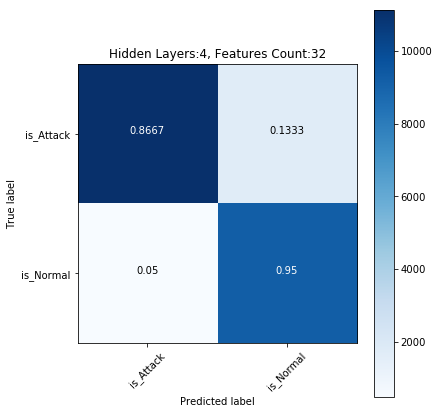

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)